In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.base_ae import BaseAutoEncoder
from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config


In [3]:
config.H_target = 2* 0.3
# config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.K_MS_SSIM=500
config.beta

500

In [4]:
import time
import datetime
import logging

logger = logging.getLogger()

def setup_file_logger(log_file='out.log'):
    hdlr = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
    logger.setLevel(logging.INFO)
    logger.info("start")

setup_file_logger()

In [5]:
class AverageMetric(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self, func,name):
        # If it's a partial, use func.func
        #         name = getattr(func,'func',func).__name__
        self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0) # batch size
        
        if last_output[0] is None:
            X_OUTPUT = 1 # X_DEC
        else:
            X_OUTPUT = 0 # X_HAT_OUT
        val = self.func(last_output[X_OUTPUT], last_target[0])
        self.val += last_target[0].size(0) * val.detach().cpu()
        
    
    
    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val/self.count)
    
class ParameterMetricCallback(Callback):
    def __init__(self,loss_man):
        self.loss_man = loss_man
    
    def on_backward_begin(self,*args, **kwargs):
        self.pbar=kwargs["pbar"]
        if hasattr(self.loss_man,'soft_bit_entropy'):
            self.pbar.child.comment += f' soft_bit_entropy: {self.loss_man.soft_bit_entropy:.4f}'

class ParameterRunningAverageMetricCallback(Callback):
    def __init__(self,loss_man,alpha=0.1):
        self.loss_man = loss_man
        self.alpha = alpha
        self.val = None
    
    def on_backward_begin(self,*args, **kwargs):
        self.pbar=kwargs["pbar"]
        self.importance_map=kwargs["last_output"][3].detach()
#         import pdb
#         pdb.set_trace()
        if hasattr(self.loss_man,'soft_bit_entropy'):
            if self.val is None:
                self.val = self.loss_man.soft_bit_entropy.detach()
            else:
                self.val *= 1 - self.alpha
                self.val += self.alpha * self.loss_man.soft_bit_entropy.detach()
                
            self.pbar.child.comment += f' avg_bpp: {self.val / 2 :.4f} imp-mean-var {(torch.mean(self.importance_map),torch.var(self.importance_map))}'
    

In [6]:
class BitEntropy(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self,loss_man,alpha=0.1, logger=logger):
        # If it's a partial, use func.func
        #         name = getattr(func,'func',func).__name__
        self.loss_man = loss_man
        self.alpha = alpha
        self.logger = logger
        
    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val = 0.0
        self.iter = 0
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
      
        self.val *= 1 - self.alpha
        self.val += self.alpha * self.loss_man.soft_bit_entropy.detach()

        if self.iter % 500 == 0 :
            importance_map  = last_output[3].detach()
            msg = f"iter {self.iter}: bpp = {self.val / 2:.3f}, impmap- mean {torch.mean(importance_map):.4f} var {torch.var(importance_map):.4f} "
            msg += f" total loss{self.loss_man.total_loss:.1f}  l2reg_loss={self.loss_man.l2_reg_loss:.1f}"
            msg += f"autoencoder_loss_value={ self.loss_man.autoencoder_loss_value:.1f}"
            msg += f"si_loss={self.loss_man.si_net_loss_value}"
            self.logger.info(msg)
            print(msg)
        self.iter += 1

    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val)
    

In [7]:
config.use_si_flag = SiNetChannelIn.WithSideInformation
config.use_si_flag

<SiNetChannelIn.WithSideInformation: 6>

In [8]:
torch.__version__

'1.5.1'

In [9]:
# x = nn.Sequential(nn.Conv2d(in_channels=2,out_channels=3 , kernel_size=1),nn.ReLU())

In [11]:
baseline_autoencoder = BaseAutoEncoder()
path = "../src/dsin/data"
pct= 1 #0.0005 #0.25

valid_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_baseline_val.txt"],pct=pct)
train_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_baseline_train.txt"],pct=pct)

image_lists = ItemLists(
    path=path, train=train_image_list, valid=valid_image_list)


tfms =  get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1., max_lighting=None, max_warp=None, p_affine=0.0, p_lighting=0.0)

batchsize = 1

data = (image_lists
        .label_from_func(lambda x: x)
        .transform(None, size=(336, 1224), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))

learn = Learner(data=data,
                     model=baseline_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(SiNetChannelIn.NoSideInformation),
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])

In [12]:

model_fname = '200815MAE-l2reg-baseline'
for i in range(1,5):
    if i != 1 :
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    
    config.si_loss_weight_alpha = 0
    learn.model.true_tuple_loss_false_just_out = True
    learn.model.use_side_infomation = SiNetChannelIn.NoSideInformation
    learn.loss_func.use_side_infomation = SiNetChannelIn.NoSideInformation
    learn.fit(1, lr=0.0001,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func)])
    learn.save(f'{model_fname}-{i}')
    !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
    !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,211.950790,242.763519,397.498230,1:36:56


iter 0: bpp = 0.092, impmap- mean 0.4480 var 0.2466  total loss753.8  l2reg_loss=37.1autoencoder_loss_value=94.8si_loss=0
iter 500: bpp = 0.542, impmap- mean 0.0656 var 0.0613  total loss319.3  l2reg_loss=34.6autoencoder_loss_value=43.0si_loss=0
iter 1000: bpp = 0.458, impmap- mean 0.1795 var 0.1472  total loss315.8  l2reg_loss=32.9autoencoder_loss_value=45.8si_loss=0
iter 1500: bpp = 0.344, impmap- mean 0.0926 var 0.0839  total loss129.7  l2reg_loss=31.9autoencoder_loss_value=26.9si_loss=0
iter 2000: bpp = 0.306, impmap- mean 0.0767 var 0.0707  total loss65.0  l2reg_loss=31.1autoencoder_loss_value=21.0si_loss=0
iter 2500: bpp = 0.306, impmap- mean 0.0938 var 0.0848  total loss72.2  l2reg_loss=30.4autoencoder_loss_value=20.1si_loss=0
iter 3000: bpp = 0.313, impmap- mean 0.1005 var 0.0903  total loss71.5  l2reg_loss=29.8autoencoder_loss_value=21.2si_loss=0
iter 3500: bpp = 0.310, impmap- mean 0.1342 var 0.1161  total loss131.4  l2reg_loss=29.2autoencoder_loss_value=25.7si_loss=0
iter 40

iter 33000: bpp = 0.510, impmap- mean 0.3199 var 0.2175  total loss234.7  l2reg_loss=32.1autoencoder_loss_value=14.3si_loss=0
iter 33500: bpp = 0.484, impmap- mean 0.2725 var 0.1982  total loss190.8  l2reg_loss=32.1autoencoder_loss_value=13.8si_loss=0
upload: ../src/dsin/data/models/200815MAE-l2reg-baseline-1.pth to s3://dsin-us/models/200815MAE-l2reg-baseline-1.pth
upload: ./out.log to s3://dsin-us/models/200815MAE-l2reg-baseline.log


epoch,train_loss,valid_loss,MS_SSIM,time


iter 0: bpp = 0.053, impmap- mean 0.3882 var 0.2375  total loss288.2  l2reg_loss=32.1autoencoder_loss_value=21.8si_loss=0
iter 500: bpp = 0.388, impmap- mean 0.2104 var 0.1661  total loss127.3  l2reg_loss=32.3autoencoder_loss_value=17.7si_loss=0
iter 1000: bpp = 0.381, impmap- mean 0.2440 var 0.1844  total loss171.2  l2reg_loss=32.4autoencoder_loss_value=18.7si_loss=0
iter 1500: bpp = 0.387, impmap- mean 0.2216 var 0.1725  total loss133.1  l2reg_loss=32.5autoencoder_loss_value=12.1si_loss=0
iter 2000: bpp = 0.383, impmap- mean 0.2216 var 0.1724  total loss140.9  l2reg_loss=32.7autoencoder_loss_value=16.5si_loss=0
iter 2500: bpp = 0.363, impmap- mean 0.1911 var 0.1545  total loss99.4  l2reg_loss=32.8autoencoder_loss_value=11.3si_loss=0
iter 3000: bpp = 0.380, impmap- mean 0.2086 var 0.1651  total loss124.2  l2reg_loss=33.0autoencoder_loss_value=18.5si_loss=0
iter 3500: bpp = 0.405, impmap- mean 0.2229 var 0.1732  total loss137.8  l2reg_loss=33.1autoencoder_loss_value=10.7si_loss=0
iter 

KeyboardInterrupt: 

In [ ]:
learn.model.my_tuple[5]


In [ ]:
learn.data.train_ds[1][0].img

In [ ]:
learn.data.train_ds[1][0].si_img

In [ ]:
learn.loss_func.soft_bit_entropy

In [ ]:
config.si_loss_weight_alpha

In [ ]:
learn.loss_func.autoencoder_loss_value

In [ ]:
learn.load('try2_200807MAE-l2reg-baseline-2')


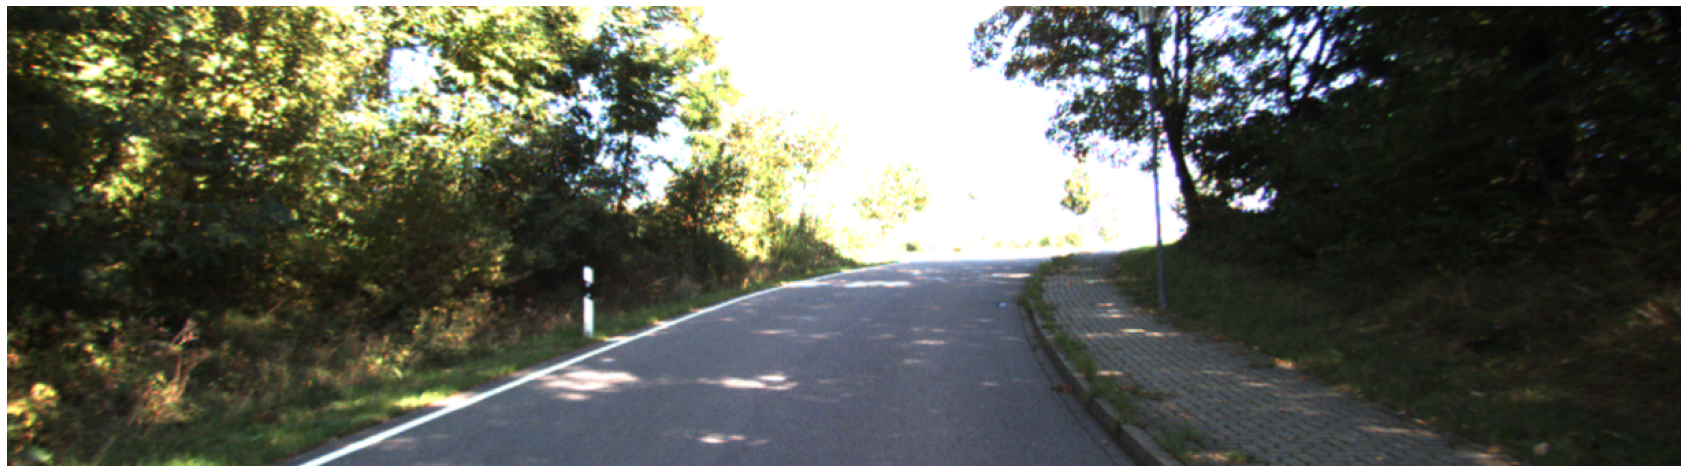

In [14]:
mt = learn.model.my_tuple[-1].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image((mt - mn)/(diff)),figsize=(30,30))
# # print(mn)

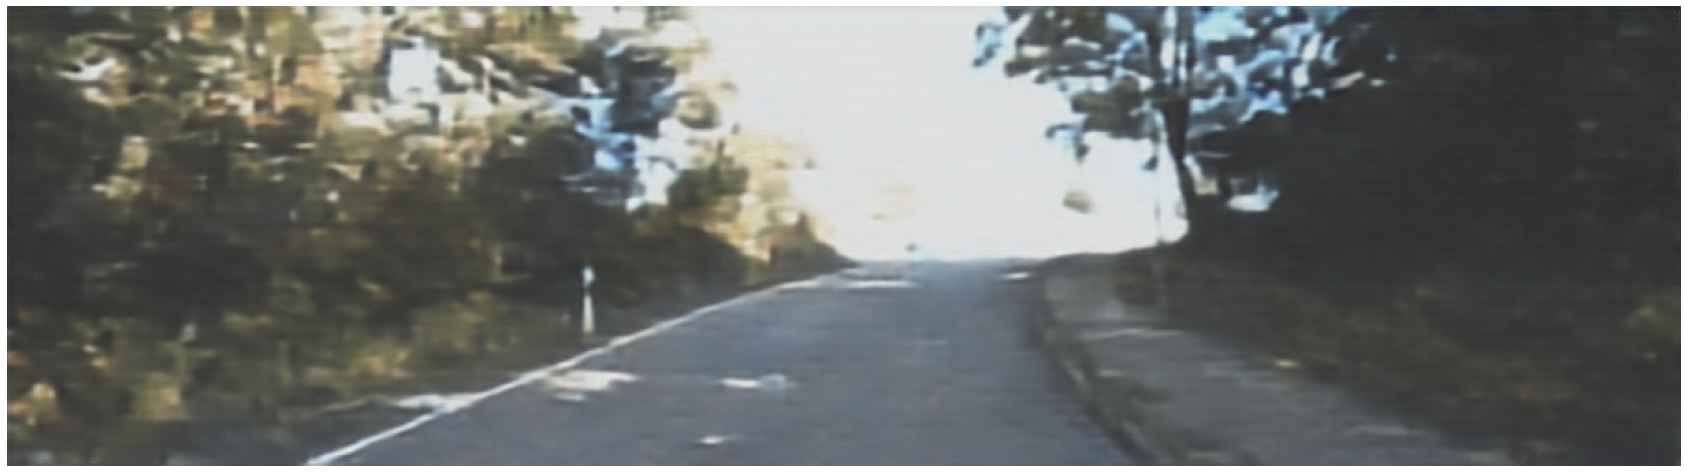

In [15]:

# # show_image(Image(learn.model.my_tuple[0][:,:50,:50]/255))
# # Image(learn.model.my_tuple[2].squeeze_().detach()/255.0)
mt = learn.model.my_tuple[0].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image((mt - mn)/(diff)),figsize=(30,30))
# # print(mn)

# torch.min(learn.model.my_tuple[2].squeeze_().detach())

In [ ]:
aaa = (mt - mn)/(diff)

flip_lr(Image(aaa.cpu()))

In [ ]:
# learn.model.true_tuple_loss_false_just_out = False

# learn.show_results(figsize=(30,30))

In [ ]:
learn.model.my_tuple[-2].data